# 06.01.c Optimize 3: Adding Interaction Terms and Select on KBest
 
Goal: identify the factors that most contribute to SLAFail

Tuning Adjustments: Focus on finding the most predictive set of predictor variables

Read Prepared Data  ->  Split Data  -> Develop Pipeline  ->  Evaluate  



In [1]:
# create dictionary to store information about the pipeline and results for later reporting and review
PipeLineMetadata = { "Name" : "Optimize Round 3: Adding Interaction Terms" }

In [41]:
outFileName = "data/06.00.c Add Interaction Terms.pkl"

In [3]:

# Load libraries
import pandas as pd
import numpy as np
import pickle
pd.options.display.float_format = '{:.7f}'.format

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFpr


from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE

from sklearn import metrics

## Read Prepared Data

In [4]:
df = pd.read_csv("data/05.00 Incident Data.csv")
print("df.shape: " + str(df.shape))
print("df.columns: " + str(df.columns))
print("df.dtypes: \n" + str(df.dtypes))

df.shape: (35208, 10)
df.columns: Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'SLAFail', 'Open_Time_HourOfDay',
       'Open_Time_DayOfWeek', 'CI_TypeSubType_aff'],
      dtype='object')
df.dtypes: 
Service_Component_WBS_aff      object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
SLAFail                         int64
Open_Time_HourOfDay             int64
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object


#### Set X and y

In [5]:
y = df.SLAFail
y.shape

(35208,)

In [6]:
X = df.drop(['SLAFail'], axis='columns')
X.shape

(35208, 9)

Set `Open_Time_HourOfDay` for recognition as a Categorical variable

In [7]:
X.Open_Time_HourOfDay = X.Open_Time_HourOfDay.astype('object')
X.dtypes

Service_Component_WBS_aff      object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
Open_Time_HourOfDay            object
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object

Create a list of numeric variable column names

In [8]:
numericVars = X.select_dtypes(include=['float64']).columns
numericVars

Index(['Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes'],
      dtype='object')

Create a list of categorical variables

In [9]:
categoricalVars = X.select_dtypes(include=['object']).columns
categoricalVars

Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Open_Time_HourOfDay', 'Open_Time_DayOfWeek', 'CI_TypeSubType_aff'],
      dtype='object')

## Split Data

Create Training and Testing Data Sets


In [10]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)


In [11]:
print(X_train.shape)
print(X_train.columns)

(24645, 9)
Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'Open_Time_HourOfDay', 'Open_Time_DayOfWeek',
       'CI_TypeSubType_aff'],
      dtype='object')


## Develop Pipeline


### Encode Variables

Numeric and categorical variables require different treatment 

Set up column transformer for scaling numeric variables and encoding categorical variables



In [12]:
column_trans = make_column_transformer(
    (ce.WOEEncoder(), categoricalVars),
    (StandardScaler(), numericVars),
    remainder='passthrough')

### Feature Selection




In [13]:
selector = SelectKBest(score_func=f_classif)

### Configure for creating the Interaction Variables using PolynomialFeatures


In [14]:
poly = PolynomialFeatures(interaction_only=True)

### Specify Classifier (Logistic Regression)

In [15]:
classifier = LogisticRegression(solver="lbfgs")

### Set Parameters for Grid Search Cross Validation

In [16]:
# selectKBestRange = list(range(1, len(X_train.columns)+1 ))
selectKBestRange = list(range(1, 55))

### Compose Pipeline

In [17]:
pipe = Pipeline(steps=[('column_trans', column_trans), 
                        ('poly',  poly),
                        ('selector',  selector),
                        ('classifier', classifier)
                        ])

### Create parameter grid


In [18]:
param_grid = dict(selector__k=selectKBestRange)

### Instantiate the search


In [19]:
search = GridSearchCV(pipe, param_grid, n_jobs=1)

In [20]:
search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('column_trans',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('woeencoder',
                                                                         WOEEncoder(cols=None,
                                                                                    drop_invariant=False,
                                                                                    handle_missing='value',
                                                                                    handle_unknown='value',
                                      

In [21]:
search.estimator.named_steps.classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
search.best_estimator_.named_steps.classifier.coef_

array([[ 1.59293354e-01,  2.91368383e-01,  1.11916076e+00,
         1.35144148e+00,  1.32715945e+00,  5.55074960e-02,
         6.52223487e-01,  4.12747947e-02, -2.23711213e-02,
        -7.06769881e-02, -8.62674909e-02,  5.39840844e-01,
        -1.45471602e-02,  1.39538363e-01,  1.26602364e-01,
         1.19745197e-01, -4.21114140e-02, -5.79452623e-02,
        -1.42263843e-01, -1.99340922e-01, -4.80149840e-01,
         6.53363482e-01, -4.52856027e-02, -4.90327229e-04,
        -5.64893436e-01, -2.03455219e-01, -7.12555558e-02,
        -4.06959906e-03, -7.27932745e-02,  5.94271895e-02,
         1.63117229e+00, -2.67207424e-01,  1.67434428e+00,
        -4.41346203e-02,  1.62837382e-03,  8.02638862e-02,
         7.85155008e-01, -1.36917851e-01, -1.42411097e-01,
         8.68015178e-02,  1.48028904e-01,  8.06941782e-02,
        -2.01599716e-02, -4.43875605e-02,  1.83345568e-02]])

In [23]:
print("Best parameter (CV score=%0.3f): %s" % (search.best_score_, search.best_params_))

Best parameter (CV score=0.745): {'selector__k': 45}


In [24]:
searchCVResults = pd.DataFrame(search.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
searchCVResults

,mean_test_score,std_test_score,params
0,0.7148712,0.0065384,{'selector__k': 1}
1,0.7156827,0.0039436,{'selector__k': 2}
2,0.7157638,0.0039298,{'selector__k': 3}
3,0.7332522,0.0056609,{'selector__k': 4}
4,0.7349158,0.0036913,{'selector__k': 5}
5,0.7359302,0.0027894,{'selector__k': 6}
6,0.7353216,0.0029220,{'selector__k': 7}
7,0.7358491,0.0029679,{'selector__k': 8}
8,0.7368229,0.0028211,{'selector__k': 9}
9,0.7373098,0.0028241,{'selector__k': 10}


## Evaluate with Testing Data

Get predicted classification and predicted probabilities based on the model

In [25]:
y_pred_class = search.predict(X_test)


In [26]:
y_pred_prob = search.predict_proba(X_test)[:,1]



In [27]:
print(metrics.classification_report(y_test, y_pred_class))

precision    recall  f1-score   support

           0       0.79      0.89      0.83      7445
           1       0.62      0.42      0.50      3118

    accuracy                           0.75     10563
   macro avg       0.70      0.66      0.67     10563
weighted avg       0.74      0.75      0.74     10563



Look at the resulting confusion matrix

Save True Positive (TP), True Negative (TN), False Positive(FP), and False Negative (FN) values

In [28]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)
print("TN: %d \t FP: %d \nFN: %d \t TP: %d " % (TN, FP, FN, TP))

[[6628  817]
 [1805 1313]]
TN: 6628 	 FP: 817 
FN: 1805 	 TP: 1313 


Capture resulting AUC

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
metrics.roc_auc_score(y_test, y_pred_prob)

0.7866722869570348

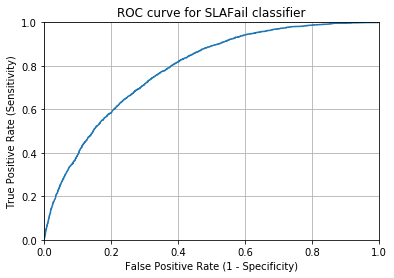

In [30]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SLAFail classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Save Details and Performance Measures for Comparison to other Models


In [31]:
PipeLineMetadata['Best Estimator Classification Intercept'] = search.best_estimator_.named_steps.classifier.intercept_
PipeLineMetadata['Best Estimator Classification Coefficients'] = search.best_estimator_.named_steps.classifier.coef_
PipeLineMetadata

{'Name': 'Optimize Round 3: Adding Interaction Terms',
 'Best Estimator Classification Intercept': array([-0.90415783]),
 'Best Estimator Classification Coefficients': array([[ 1.59293354e-01,  2.91368383e-01,  1.11916076e+00,
          1.35144148e+00,  1.32715945e+00,  5.55074960e-02,
          6.52223487e-01,  4.12747947e-02, -2.23711213e-02,
         -7.06769881e-02, -8.62674909e-02,  5.39840844e-01,
         -1.45471602e-02,  1.39538363e-01,  1.26602364e-01,
          1.19745197e-01, -4.21114140e-02, -5.79452623e-02,
         -1.42263843e-01, -1.99340922e-01, -4.80149840e-01,
          6.53363482e-01, -4.52856027e-02, -4.90327229e-04,
         -5.64893436e-01, -2.03455219e-01, -7.12555558e-02,
         -4.06959906e-03, -7.27932745e-02,  5.94271895e-02,
          1.63117229e+00, -2.67207424e-01,  1.67434428e+00,
         -4.41346203e-02,  1.62837382e-03,  8.02638862e-02,
          7.85155008e-01, -1.36917851e-01, -1.42411097e-01,
          8.68015178e-02,  1.48028904e-01,  8.0694178

In [32]:
PipeLineMetadata['Column Transforms'] = search.best_estimator_.named_steps.column_trans.transformers
PipeLineMetadata['Best SearchGridCV score'] = search.best_score_
PipeLineMetadata['Best SearchGridCV parameters'] = search.best_params_

In [33]:
PipeLineMetadata['Selector'] = search.best_estimator_.named_steps.selector
PipeLineMetadata['Classifier'] = search.best_estimator_.named_steps.classifier
PipeLineMetadata['PolynomialFeatures'] = search.best_estimator_.named_steps.poly

In [34]:
PipeLineMetadata['Selector - Scores'] = pd.DataFrame( 
    [ search.best_estimator_.named_steps.poly.get_feature_names(X_test.columns)[1:], 
      search.best_estimator_.named_steps.selector.scores_[1:], 
      search.best_estimator_.named_steps.selector.pvalues_[1:] 
    ], 
    index=['feature names', 'scores','p-value'] 
    ).transpose()
PipeLineMetadata  

{'Name': 'Optimize Round 3: Adding Interaction Terms',
 'Best Estimator Classification Intercept': array([-0.90415783]),
 'Best Estimator Classification Coefficients': array([[ 1.59293354e-01,  2.91368383e-01,  1.11916076e+00,
          1.35144148e+00,  1.32715945e+00,  5.55074960e-02,
          6.52223487e-01,  4.12747947e-02, -2.23711213e-02,
         -7.06769881e-02, -8.62674909e-02,  5.39840844e-01,
         -1.45471602e-02,  1.39538363e-01,  1.26602364e-01,
          1.19745197e-01, -4.21114140e-02, -5.79452623e-02,
         -1.42263843e-01, -1.99340922e-01, -4.80149840e-01,
          6.53363482e-01, -4.52856027e-02, -4.90327229e-04,
         -5.64893436e-01, -2.03455219e-01, -7.12555558e-02,
         -4.06959906e-03, -7.27932745e-02,  5.94271895e-02,
          1.63117229e+00, -2.67207424e-01,  1.67434428e+00,
         -4.41346203e-02,  1.62837382e-03,  8.02638862e-02,
          7.85155008e-01, -1.36917851e-01, -1.42411097e-01,
          8.68015178e-02,  1.48028904e-01,  8.0694178

In [35]:
#pipenew.estimator.named_steps.poly.get_feature_names(X_train.columns)
PipeLineMetadata['Selector - Scores'].loc[ PipeLineMetadata['Selector - Scores']['p-value'] <= 0.05 ].sort_values('p-value')

,feature names,scores,p-value
0,Service_Component_WBS_aff,2626.0557182,0.0000000
2,KM_number,6104.4383936,0.0000000
5,Count_Related_Changes,902.1087202,0.0000000
4,Count_Related_Incidents,679.7626961,0.0000000
3,Count_Related_Interactions,177.7555436,0.0000000
26,KM_number Count_Related_Changes,177.0139338,0.0000000
1,Urgency,141.5836070,0.0000000
30,Count_Related_Interactions Count_Related_Incid...,126.4500112,0.0000000
17,Urgency KM_number,77.5772795,0.0000000
6,Open_Time_HourOfDay,62.0757993,0.0000000


Capture a few classification metrics:
* Classification Accuracy: Overall, how often is the classifier correct?
* Classification Error: Overall, how often is the classifier incorrect?
* True Positive Rate  (Recall, Sensitivity): When the actual value is positive, how often is the prediction correct?
* True Negative Rate (Specificity): When the actual value is negative, how often is the prediction correct?
* False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
* Precision: When a positive value is predicted, how often is the prediction correct?


In [36]:
PipeLineMetadata['Metrics - Classification Report'] = metrics.classification_report(y_test, y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix'] =metrics.confusion_matrix(y_test, y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix Classification Accuracy'] = metrics.accuracy_score(y_test,y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix Classification Error'] = 1- metrics.accuracy_score(y_test,y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix True Positive Rate'] = metrics.recall_score(y_test, y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix True Negative Rate'] =  TN / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix False Positive Rate'] =  FP / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix Precision'] = metrics.precision_score(y_test,y_pred_class)


In [37]:
PipeLineMetadata['Metrics - AUC'] = metrics.roc_auc_score(y_test, y_pred_prob)

In [38]:
PipeLineMetadata['Metrics - ROC Curve fpr array'] = fpr
PipeLineMetadata['Metrics - ROC Curve tpr array'] = tpr

In [39]:
PipeLineMetadata

{'Name': 'Optimize Round 3: Adding Interaction Terms',
 'Best Estimator Classification Intercept': array([-0.90415783]),
 'Best Estimator Classification Coefficients': array([[ 1.59293354e-01,  2.91368383e-01,  1.11916076e+00,
          1.35144148e+00,  1.32715945e+00,  5.55074960e-02,
          6.52223487e-01,  4.12747947e-02, -2.23711213e-02,
         -7.06769881e-02, -8.62674909e-02,  5.39840844e-01,
         -1.45471602e-02,  1.39538363e-01,  1.26602364e-01,
          1.19745197e-01, -4.21114140e-02, -5.79452623e-02,
         -1.42263843e-01, -1.99340922e-01, -4.80149840e-01,
          6.53363482e-01, -4.52856027e-02, -4.90327229e-04,
         -5.64893436e-01, -2.03455219e-01, -7.12555558e-02,
         -4.06959906e-03, -7.27932745e-02,  5.94271895e-02,
          1.63117229e+00, -2.67207424e-01,  1.67434428e+00,
         -4.41346203e-02,  1.62837382e-03,  8.02638862e-02,
          7.85155008e-01, -1.36917851e-01, -1.42411097e-01,
          8.68015178e-02,  1.48028904e-01,  8.0694178

In [40]:
with open(outFileName,'wb') as fo:
    pickle.dump(PipeLineMetadata, fo)